# Feature Engineering: Sentiment Analysis on Customer Financial Statements

This notebook performs sentiment analysis on customer financial statements using the Gemini API.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import google.generativeai as genai
from tqdm import tqdm
import time

In [2]:
# Load environment variables
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

# Configure Gemini API
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel('gemini-3-flash-preview')

In [3]:
# Load the credit risk dataset
df = pd.read_csv('data/credit_risk_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1500, 17)

Columns: ['age', 'monthly_income', 'credit_utilization_ratio', 'loan_amount', 'loan_duration_months', 'num_late_payments', 'existing_loans_count', 'account_tenure_years', 'employment_type', 'education_level', 'marital_status', 'region', 'customer_financial_statement', 'sentiment', 'financial_stress_level', 'risk_category', 'default_risk']

First few rows:


,age,monthly_income,credit_utilization_ratio,loan_amount,loan_duration_months,num_late_payments,existing_loans_count,account_tenure_years,employment_type,education_level,marital_status,region,customer_financial_statement,sentiment,financial_stress_level,risk_category,default_risk
0,22,1800,0.92,7500,36,4,2,1,Student,Bachelor,Single,Urban,I'm really struggling to make ends meet each m...,Negative,High,High Risk,1
1,45,12500,0.18,30000,48,0,1,15,Salaried,Master,Married,Suburban,"My finances are stable, and I'm actively savin...",Positive,Low,Low Risk,0
2,38,6800,0.68,22000,60,2,3,8,Salaried,Bachelor,Married,Urban,"We're managing, but recent unexpected expenses...",Neutral,Medium,Watchlist,1
3,55,4500,0.35,10000,24,1,0,20,Self-Employed,Diploma,Divorced,Rural,I'm comfortable with my current financial situ...,Positive,Low,Low Risk,0
4,28,3200,0.85,12000,48,3,1,3,Salaried,Bachelor,Single,Urban,I'm constantly worried about my credit card de...,Negative,High,High Risk,1


In [4]:
# Display sample customer financial statements
print("Sample customer financial statements:")
for i in range(min(3, len(df))):
    print(f"\n{i+1}. {df['customer_financial_statement'].iloc[i]}")

Sample customer financial statements:

1. I'm really struggling to make ends meet each month, balancing tuition and living costs.

2. My finances are stable, and I'm actively saving for my children's education and retirement.

3. We're managing, but recent unexpected expenses have made cash flow a bit tight.


In [5]:
# Function to analyze sentiment using Gemini API
def analyze_sentiment(text):
    """
    Analyze sentiment of customer financial statement using Gemini API.
    Returns a sentiment score between 0 and 1.
    0 = Very negative sentiment (high risk)
    1 = Very positive sentiment (low risk)
    """
    try:
        prompt = f"""Analyze the sentiment of the following customer financial statement and provide a sentiment score between 0 and 1.
        
A score of 0 indicates very negative sentiment (financial distress, high risk, poor financial health).
A score of 1 indicates very positive sentiment (financial stability, low risk, good financial health).

Customer Financial Statement:
{text}

Respond with ONLY a single decimal number between 0 and 1, nothing else. For example: 0.75"""
        
        response = model.generate_content(prompt)
        
        # Extract the sentiment score from response
        sentiment_score = float(response.text.strip())
        
        # Ensure score is between 0 and 1
        sentiment_score = max(0.0, min(1.0, sentiment_score))
        
        return sentiment_score
    
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 0.5  # Return neutral score on error

In [6]:
# Test the sentiment analysis function on a sample
sample_statement = df['customer_financial_statement'].iloc[0]
print(f"Sample statement: {sample_statement}")
print(f"\nSentiment score: {analyze_sentiment(sample_statement)}")

Sample statement: I'm really struggling to make ends meet each month, balancing tuition and living costs.

Sentiment score: 0.15


In [7]:
# Apply sentiment analysis to all customer financial statements
print("Analyzing sentiment for all customer financial statements...")
print("This may take a few minutes depending on the dataset size.\n")

sentiments = []

for idx, statement in tqdm(enumerate(df['customer_financial_statement']), total=len(df)):
    sentiment_score = analyze_sentiment(statement)
    sentiments.append(sentiment_score)
    
    # Add a small delay to avoid rate limiting
    if (idx + 1) % 10 == 0:
        time.sleep(1)

# Add sentiment column to dataframe
df['sentiment'] = sentiments

print("\nSentiment analysis complete!")

Analyzing sentiment for all customer financial statements...
This may take a few minutes depending on the dataset size.



100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:23:56<00:00,  3.36s/it]


Sentiment analysis complete!


In [8]:
# Display statistics about the sentiment scores
print("Sentiment Score Statistics:")
print(df['sentiment'].describe())

print("\nSample of data with sentiment scores:")
df[['customer_financial_statement', 'sentiment']].head(10)

Sentiment Score Statistics:
count    1500.000000
mean        0.538513
std         0.336071
min         0.000000
25%         0.200000
50%         0.550000
75%         0.900000
max         1.000000
Name: sentiment, dtype: float64

Sample of data with sentiment scores:


,customer_financial_statement,sentiment
0,I'm really struggling to make ends meet each m...,0.15
1,"My finances are stable, and I'm actively savin...",0.90
2,"We're managing, but recent unexpected expenses...",0.35
3,I'm comfortable with my current financial situ...,0.80
4,I'm constantly worried about my credit card de...,0.15
5,"My retirement planning is well underway, and I...",0.95
6,"I'm trying to pay down my debts, but it feels ...",0.30
7,"My business is thriving, and I have significan...",0.95
8,"I'm working hard, but it's tough to get ahead ...",0.35
9,"Our family budget is well-managed, allowing fo...",0.90


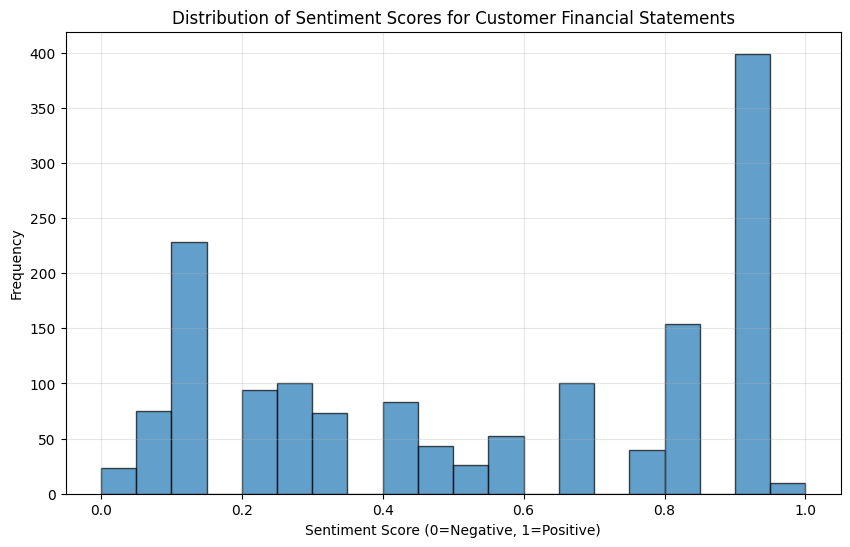

In [9]:
# Visualize sentiment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['sentiment'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score (0=Negative, 1=Positive)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Customer Financial Statements')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Save the updated dataset with sentiment scores
output_path = 'data/credit_risk_dataset_with_sentiment.csv'
df.to_csv(output_path, index=False)
print(f"Dataset with sentiment scores saved to: {output_path}")

Dataset with sentiment scores saved to: data/credit_risk_dataset_with_sentiment.csv


In [11]:
# Analyze correlation between sentiment and default risk
if 'default_risk' in df.columns:
    correlation = df['sentiment'].corr(df['default_risk'])
    print(f"Correlation between sentiment and default_risk: {correlation:.4f}")
    
    # Group by default risk and show average sentiment
    print("\nAverage sentiment by default risk:")
    print(df.groupby('default_risk')['sentiment'].mean())

Correlation between sentiment and default_risk: -0.8323

Average sentiment by default risk:
default_risk
0    0.750346
1    0.169452
Name: sentiment, dtype: float64
